<a href="https://colab.research.google.com/github/Sachin0527/my_project1/blob/master/Fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import relevant modules and install Facets
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

from google.colab import widgets
# For facets
from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.1.1
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

In [2]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

train_csv = tf.keras.utils.get_file('adult.data',
  'https://download.mlcc.google.com/mledu-datasets/adult_census_train.csv')
test_csv = tf.keras.utils.get_file('adult.test' ,
  'https://download.mlcc.google.com/mledu-datasets/adult_census_test.csv')

train_df = pd.read_csv(train_csv, names=COLUMNS, sep=r'\s*,\s*',
                       engine='python', na_values="?")
test_df = pd.read_csv(test_csv, names=COLUMNS, sep=r'\s*,\s*', skiprows=[0],
                      engine='python', na_values="?")
# Strip trailing periods mistakenly included only in UCI test dataset.
test_df['income_bracket'] = test_df.income_bracket.str.rstrip('.')

2003153/2003153 [==============================] - 0s 0us/step


In [3]:
#@title Visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [4]:
#@title Set the Number of Data Points to Visualize in Facets Dive

SAMPLE_SIZE = 5000 #@param

train_dive = train_df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=train_dive)
display(HTML(html))

In [5]:
feature = 'fnlwgt' #@param ["", "hours_per_week", "fnlwgt", "gender", "capital_gain / capital_loss", "age"] {allow-input: false}


if feature == "hours_per_week":
  print(
'''It does seem a little strange to see 'hours_per_week' max out at 99 hours,
which could lead to data misrepresentation. One way to address this is by
representing 'hours_per_week' as a binary "working 40 hours/not working 40
hours" feature. Also keep in mind that data was extracted based on work hours
being greater than 0. In other words, this feature representation exclude a
subpopulation of the US that is not working. This could skew the outcomes of the
model.''')
if feature == "fnlwgt":
  print(
"""'fnlwgt' represents the weight of the observations. After fitting the model
to this data set, if certain group of individuals end up performing poorly
compared to other groups, then we could explore ways of reweighting each data
point using this feature.""")
if feature == "gender":
  print(
"""Looking at the ratio between men and women shows how disproportionate the data
is compared to the real world where the ratio (at least in the US) is closer to
1:1. This could pose a huge probem in performance across gender. Considerable
measures may need to be taken to upsample the underrepresented group (in this
case, women).""")
if feature == "capital_gain / capital_loss":
  print(
"""As alluded to in Task #1, both 'capital_gain' and 'capital_loss' could be
indicative of income status as only individuals who make investments register
their capital gains and losses. The caveat is that over 90% of the values in
both 'capital_gain' and 'capital_loss' are 0, and it's not entirely clear from
the description of the data set why that is the case. That is, we don't know
whether we should interpret all these 0s as "no investment gain/loss or "
investment gain/loss is unknown." Lack of context is always a flag for concern,
and one that could trigger fairness-related issues later on. For now, we are
going to omit these features from the model, but you are more than welcome to
experiment with them if you come up with an idea on how capital gains and
losses should be handled.""")
if feature == "age":
  print(
'''"age" has a lot of variance, so it might benefit from bucketing to learn
fine-grained correlations between income and age, as well as to prevent
overfitting.''')

'fnlwgt' represents the weight of the observations. After fitting the model
to this data set, if certain group of individuals end up performing poorly
compared to other groups, then we could explore ways of reweighting each data
point using this feature.


In [6]:
def pandas_to_numpy(data):
  '''Convert a pandas DataFrame into a Numpy array'''
  # Drop empty rows.
  data = data.dropna(how="any", axis=0)

  # Separate DataFrame into two Numpy arrays.
  labels = np.array(data['income_bracket'] == ">50K")
  features = data.drop('income_bracket', axis=1)
  features = {name:np.array(value) for name, value in features.items()}

  return features, labels

In [7]:
#@title Create categorical feature columns

# Since we don't know the full range of possible values with occupation and
# native_country, we'll use categorical_column_with_hash_bucket() to help map
# each feature string into an integer ID.
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    "occupation", hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket(
    "native_country", hash_bucket_size=1000)

# For the remaining categorical features, since we know what the possible values
# are, we can be more explicit and use categorical_column_with_vocabulary_list()
gender = tf.feature_column.categorical_column_with_vocabulary_list(
    "gender", ["Female", "Male"])
race = tf.feature_column.categorical_column_with_vocabulary_list(
    "race", [
        "White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"
    ])
education = tf.feature_column.categorical_column_with_vocabulary_list(
    "education", [
        "Bachelors", "HS-grad", "11th", "Masters", "9th",
        "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
        "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
        "Preschool", "12th"
    ])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    "marital_status", [
        "Married-civ-spouse", "Divorced", "Married-spouse-absent",
        "Never-married", "Separated", "Married-AF-spouse", "Widowed"
    ])
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    "relationship", [
        "Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
        "Other-relative"
    ])
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    "workclass", [
        "Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
        "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"
    ])

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [8]:
#@title Create numeric feature columns
# For Numeric features, we can just call on feature_column.numeric_column()
# to use its raw value instead of having to create a map between value and ID.
age = tf.feature_column.numeric_column("age")
fnlwgt = tf.feature_column.numeric_column("fnlwgt")
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [9]:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [10]:
# List of variables, with special handling for gender subgroup.
variables = [native_country, education, occupation, workclass,
             relationship, age_buckets]
subgroup_variables = [gender]
feature_columns = variables + subgroup_variables

In [11]:
deep_columns = [
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(age_buckets),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.embedding_column(native_country, dimension=8),
    tf.feature_column.embedding_column(occupation, dimension=8),
]

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [12]:
#@title Define Deep Neural Net Model

# Parameters from form fill-ins
HIDDEN_UNITS_LAYER_01 = 128 #@param
HIDDEN_UNITS_LAYER_02 = 64 #@param
LEARNING_RATE = 0.1 #@param
L1_REGULARIZATION_STRENGTH = 0.001 #@param
L2_REGULARIZATION_STRENGTH = 0.001 #@param

RANDOM_SEED = 512
tf.random.set_seed(RANDOM_SEED)

# List of built-in metrics that we'll need to evaluate performance.
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'),
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc'),
]

regularizer = tf.keras.regularizers.l1_l2(
    l1=L1_REGULARIZATION_STRENGTH, l2=L2_REGULARIZATION_STRENGTH)

model = tf.keras.Sequential([
  layers.DenseFeatures(deep_columns),
  layers.Dense(
      HIDDEN_UNITS_LAYER_01, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      HIDDEN_UNITS_LAYER_02, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      1, activation='sigmoid', kernel_regularizer=regularizer)
])

model.compile(optimizer=tf.keras.optimizers.Adagrad(LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [13]:
#@title Fit Deep Neural Net Model to the Adult Training Dataset

EPOCHS = 10 #@param
BATCH_SIZE = 500 #@param

features, labels = pandas_to_numpy(train_df)
model.fit(x=features, y=labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
61/61 [==============================] - 3s 11ms/step - loss: 1.8380 - tp: 1754.0000 - fp: 721.0000 - tn: 21933.0000 - fn: 5754.0000 - accuracy: 0.7853 - precision: 0.7087 - recall: 0.2336 - auc: 0.8081
Epoch 2/10
61/61 [==============================] - 0s 8ms/step - loss: 1.4231 - tp: 3778.0000 - fp: 1515.0000 - tn: 21139.0000 - fn: 3730.0000 - accuracy: 0.8261 - precision: 0.7138 - recall: 0.5032 - auc: 0.8693
Epoch 3/10
61/61 [==============================] - 1s 9ms/step - loss: 1.1227 - tp: 3995.0000 - fp: 1602.0000 - tn: 21052.0000 - fn: 3513.0000 - accuracy: 0.8304 - precision: 0.7138 - recall: 0.5321 - auc: 0.8771
Epoch 4/10
61/61 [==============================] - 0s 8ms/step - loss: 0.8871 - tp: 4040.0000 - fp: 1640.0000 - tn: 21014.0000 - fn: 3468.0000 - accuracy: 0.8306 - precision: 0.7113 - recall: 0.5381 - auc: 0.8783
Epoch 5/10
61/61 [==============================] - 1s 12ms/step - loss: 0.7068 - tp: 3984.0000 - fp: 1613.0000 - tn: 21041.0000 - fn: 3524.0000

In [14]:
#@title Evaluate Deep Neural Net Performance

features, labels = pandas_to_numpy(test_df)
model.evaluate(x=features, y=labels);

471/471 [==============================] - 5s 6ms/step - loss: 0.4231 - tp: 2147.0000 - fp: 1032.0000 - tn: 10328.0000 - fn: 1553.0000 - accuracy: 0.8284 - precision: 0.6754 - recall: 0.5803 - auc: 0.8794


In [15]:
#@title Define Function to Visualize Binary Confusion Matrix
def plot_confusion_matrix(
    confusion_matrix, class_names, subgroup, figsize = (8,6)):
  # We're taking our calculated binary confusion matrix that's already in the
  # form of an array and turning it into a pandas DataFrame because it's a lot
  # easier to work with a pandas DataFrame when visualizing a heat map in
  # Seaborn.
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  rcParams.update({
  'font.family':'sans-serif',
  'font.sans-serif':['Liberation Sans'],
  })

  sns.set_context("notebook", font_scale=1.25)

  fig = plt.figure(figsize=figsize)

  plt.title('Confusion Matrix for Performance Across ' + subgroup)

  # Combine the instance (numercial value) with its description
  strings = np.asarray([['True Positives', 'False Negatives'],
                        ['False Positives', 'True Negatives']])
  labels = (np.asarray(
      ["{0:g}\n{1}".format(value, string) for string, value in zip(
          strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

  heatmap = sns.heatmap(df_cm, annot=labels, fmt="",
      linewidths=2.0, cmap=sns.color_palette("GnBu_d"));
  heatmap.yaxis.set_ticklabels(
      heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  heatmap.xaxis.set_ticklabels(
      heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
  plt.ylabel('References')
  plt.xlabel('Predictions')
  return fig

,ACCURACY,PRECISION,RECALL,AUC
Male,0.7877,0.6750,0.6067,0.8535


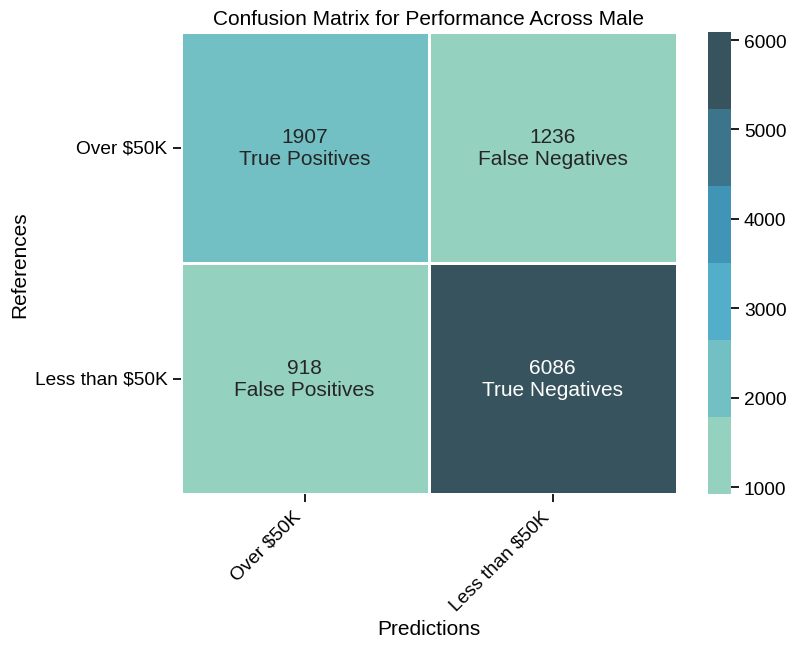

In [16]:
#@title Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Male" #@param {type:"string"}

# Labels for annotating axes in plot.
classes = ['Over $50K', 'Less than $50K']

# Given define subgroup, generate predictions and obtain its corresponding
# ground truth.
subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]],
                             [subgroup_results[2], subgroup_results[3]]])

subgroup_performance_metrics = {
    'ACCURACY': subgroup_results[5],
    'PRECISION': subgroup_results[6],
    'RECALL': subgroup_results[7],
    'AUC': subgroup_results[8]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df

In [17]:
# Filter data for the specified subgroup
subgroup_filter = test_df.loc[test_df[CATEGORY] == SUBGROUP]

# Convert the filtered data to NumPy arrays
subgroup_features, subgroup_labels = pandas_to_numpy(subgroup_filter)

# Make predictions using the model
predictions = model.predict(x=subgroup_features)

# Display some predicted values
predicted_values = predictions[:5]  # Displaying the first 5 predictions as an example
print("Predicted Values:")
print(predicted_values)


318/318 [==============================] - 1s 2ms/step
Predicted Values:
[[0.00880251]
 [0.1929185 ]
 [0.30822024]
 [0.36060324]
 [0.01863262]]


In [27]:
# Assuming you have a new data point with features, let's call it 'new_data'
# Ensure 'new_data' has the same structure as your training data
# Example new data point:
new_data = {
   'age': 49,
   'workclass': 'Private',
   'fnlwgt': 160187,
   'education': '9th',
   'education_num': 5,
   'marital_status': ' Married-spouse-absent',
   'occupation': ' Other-service',
   'relationship': 'Not-in-family',
   'race': 'Black',
   'gender': 'Female',
   'capital_gain': 0,
   'capital_loss': 0,
   'hours_per_week': 16,
   'native_country': 'United-States'
}
# Convert the new data to a Pandas DataFrame
new_df = pd.DataFrame([new_data])
# Use the pandas_to_numpy function to convert the DataFrame to NumPy arrays
#new_features, _ = pandas_to_numpy(new_df)
# Make predictions using the trained model
features = {name:np.array(value) for name, value in new_df.items()}
predictions = model.predict(features)
# Print the predicted income
predicted_income = ">50K" if predictions[0][0] > 0.5 else "<=50K"
print(f"Predicted Income: {predicted_income}")



1/1 [==============================] - 0s 32ms/step
Predicted Income: <=50K
